# 分析新聞詞彙與股價變動的關係

- 以股價漲跌區分新聞中的高頻詞
- 20161207 ~20180123期間的工商時報新聞

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from collections import Counter

### 計算股價漲跌率

In [2]:
def get_price_change_ratio_with_date(date):
    (arr_date,arr_ratio) = get_price_change_ratio()
    for i,d in enumerate(arr_date):
        if d == date:
            return arr_ratio[i]

In [3]:
def get_price_change_ratio():
    data_file = './News_stock_price/News_Stock_price.csv';
    df = pd.read_csv(data_file)
    arr_date = df['Date']
    arr_price = df['After_price'] - df['Now_price']
    arr_ratio = arr_price / df['Now_price'] * 100
    return (arr_date,arr_ratio)

### 從CSV檔取出新聞原文

In [4]:
def get_news_with_date(date):
    txt = ''
    date = date.replace('-','_')
    file_path = './ctee_TSMC/tmc_' + date + '.csv'
    if os.path.isfile(file_path):
        with open(file_path) as f:  
            txt = f.readlines()[1:]
    else:
        print(file_path + ' does not exist.')
    return txt

### 從JSON檔取出標註詞彙

In [5]:
def get_token_from_file(file_path):
    arr_token = []
    with open(file_path) as json_file:  
        data = json.load(json_file)
        for e in data['entities']:
            text = e['offsets'][0]['text']
            arr_token.append(text)
    return arr_token

In [6]:
def get_token_with_date(date):
    date = date.replace('-','')
    file_path = './NER_human_label/' + date + '.ann.json'
    if os.path.isfile(file_path):
        return get_token_from_file(file_path)
    else:
        return None

In [7]:
def get_all_tokens():
    all_tokens = []
    data_path = './NER_human_label'
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        if os.path.isfile(file_path):
            tokens = get_token_from_file(file_path)
            all_tokens = all_tokens + tokens
    return all_tokens

### 以股價漲跌閾值將新聞分群，取出標注詞

In [8]:
def get_token_with_price_trend_threshold(trend,threshold):
    arr_words = []
    (arr_date,arr_ratio) = get_price_change_ratio()
    if trend == 1:
        for i,r in enumerate(arr_ratio):
            if r >= threshold:
                d = arr_date[i]
                tokens = get_token_with_date(d)
                if tokens != None:
                    arr_words = arr_words + tokens
    elif trend == 0:
        for i,r in enumerate(arr_ratio):
            if r <= threshold:
                d = arr_date[i]
                tokens = get_token_with_date(d)
                if tokens != None:
                    arr_words = arr_words + tokens
    return arr_words

### 觀察漲跌股價與新聞數量的關係

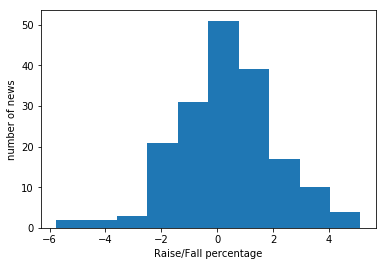

In [9]:
%matplotlib inline
(arr_date,arr_ratio) = get_price_change_ratio()
plt.hist(arr_ratio)
plt.xlabel('Raise/Fall percentage')
plt.ylabel('number of news')
plt.show()

### 統計全部標注詞

In [10]:
all_tokens = get_all_tokens()
all_counter = Counter(all_tokens)
print('共',len(all_tokens),'字')
print('共',len(all_counter),'不重複的字')

共 502 字
共 349 不重複的字


### 列出全部標註詞

In [11]:
tokens_tuple = all_counter.most_common(500)
all_unique_tokens = []
for t in tokens_tuple:
    all_unique_tokens.append(t[0])
print(all_unique_tokens)

['營收', '市值', 'ADR', '先進製程', '蘋果', '股價', '外資', '創新高', '成長', '創新', '產能', '法說會', '人工智慧', '新高', '創', '比特幣', '挖礦', '買超', '成長動能', '營運', '大漲', '歷史新高', '盤中', '量產', '匯率', '新廠', '手機晶片', '投入', '小跌', '獨吞', '訂單', '貼息', '開低', '上漲', '7奈米製程', '下滑', 'AI', '出貨', '億元', '填息', '美國科技股', '多頭', '攀高', '增加', '降評', '天價', '台股', '轉投資', '跳槽', '法人', '外資圈', '資本支出', '領先同業', '智慧型手機', '風險試產', '升破', '處理器', '季增', '造成影響', '毛利率', '台灣', 'A11', 'ASIC', '5G', '南京', '受惠', '成長率', '劉德音', '董事會', '資本預算', '建廠計畫', '大單到手', '超旺', '優化', '製程', '鰭式場效電晶體', 'FinFET', '進入量產', '繪圖晶片', '超級電腦晶片', '大單', '到位', '技術', '資金', '信評', '信用評等', '一等一', '標準普爾全球評級', '中華信評', '全球長期信評', 'A+', '本地評等', 'twAAA', '收復季線', '逆勢開高', '回到季線', '公布', '肥單', '下跌', '跌幅', '上周', '小漲', '召開法說會', '股價開高', '股價震盪走揚', '先買後賣', '行動裝置', '高速運算平台', 'A11處理器', '大量出貨', '10奈米製程', '出貨快速成長', '營收創新高', '預期', '成長趨勢', '脆弱時刻', '持續攀高', '改寫新高', '年過80', '接班問題', '手機市場', '成長減緩', '衝破', '台灣之光', '穩定成長', '景氣', '正向', '利多', '買盤簇擁', '突破', '下單量不減', '高檔水準', '歷史', '紀錄', '營收目標', '達陣', '拉長', '棄息賣壓', '收小黑', '外資賣超', '填

### 篩出漲幅超過1%的新聞，取出前10名高頻詞

In [12]:
positive_tokens = get_token_with_price_trend_threshold(1,1)
positive_counter = Counter(positive_tokens)
positive_tokens_tuple = positive_counter.most_common(10)
print(positive_tokens_tuple)

[('ADR', 7), ('市值', 4), ('營收', 4), ('創新高', 3), ('成長動能', 3), ('蘋果', 3), ('匯率', 3), ('創', 3), ('新高', 3), ('先進製程', 3)]


### 篩出跌幅超過1%的新聞，取出前10名高頻詞

In [13]:
negative_tokens = get_token_with_price_trend_threshold(0,-1)
negative_counter = Counter(negative_tokens)
negative_tokens_tuple = negative_counter.most_common(10)
print(negative_tokens_tuple)

[('營收', 3), ('跳槽', 2), ('降評', 2), ('市值', 2), ('法說會', 1), ('外資圈', 1), ('7奈米製程', 1), ('現金股利', 1), ('資本支出', 1), ('營收季減', 1)]


### 觀察結果:
- 兩方都出現的詞為：營收, 市值
- 後勢為漲的詞為：'ADR', '創新高', '成長動能', '蘋果', '匯率', '先進製程'
- 後勢為跌的詞為：'跳槽', '降評', '營收季減'

# 經濟詞彙與股價漲跌之相關性驗證

### 過濾出包含經濟詞彙的新聞 (以"ADR"為例)

In [14]:
def get_sentences_from_file(file):
    lines = []
    if os.path.isfile(file):
        with open(file_path) as f:
            txt = f.readlines()[3:]
            txt = ''.join(txt)
            txt = txt.replace('\n','。')
            lines = txt.split('。')
    return lines

In [15]:
token = 'ADR'
arr_dates = []
arr_news = []
data_path = './ctee_TSMC'
for file in os.listdir(data_path):
    file_path = os.path.join(data_path,file)
    if not file.startswith('.') : 
        date = file_path.replace('./ctee_TSMC/tmc_','').replace('.csv','')
        lines = get_sentences_from_file(file_path)
        arr_sentences = []
        for line in lines:
            if token in line:
                arr_sentences.append(line)
        if len(arr_sentences) > 0:
            arr_dates.append(date)
            arr_news.append(arr_sentences)
        
print('共',len(arr_news),'篇新聞包含該經濟詞彙\n')
for i,n in enumerate(arr_news):
    date = arr_dates[i]
    date = date.replace('_','-')
    price = get_price_change_ratio_with_date(date)
    print(date)
    print('漲跌幅',"%.2f" % price,'%')
    print(n,'\n')

共 12 篇新聞包含該經濟詞彙

2019-03-14
漲跌幅 2.01 %
['台積電靠著ADR上漲及外資看好未來的營運，花旗環球證券調升台積電至300元，漲勢強勁'] 

2019-02-18
漲跌幅 2.98 %
['儘管上周五台積電（2330）突然調降財測，引發各界負面揣測，然台積電美國存託憑證（ADR）上周五收盤小漲0.08％收38.09美元，台股今（18）日開盤，台積電直接開高，力甩降財測利空，早盤高點來到230.5元，上漲1.54％'] 

2018-01-15
漲跌幅 2.48 %
['台積電ADR上周五小漲', '台積電ADR上周五收盤為41.19美元，上漲0.16美元或0.39%，折合台幣每股約243.84元'] 

2017-10-11
漲跌幅 -0.28 %
['台積電ADR周二再創歷史新高價'] 

2017-02-02
漲跌幅 -0.09 %
['台積電ADR在台股春節封關期間維持高檔，台積電(2330)董事長張忠謀在夏威夷跌倒並無大礙，台積電雞年開紅盤，股價開高2.5元為188元，延續台股於封關前的漲勢'] 

2019-02-20
漲跌幅 0.63 %
['19日美股早盤，台積電ADR上漲0.75％，至38.385美元，顯示投資人對台積新的股利政策反應正向'] 

2018-01-23
漲跌幅 1.18 %
['台積電ADR周一大漲3.83%，並再創收盤新天價'] 

2017-09-06
漲跌幅 0.69 %
['台積電尚未接獲通知，強調公司一向遵循法規，台積電ADR周三小跌0.99%，台積電今早開低1.5元，盤中回到平盤218元'] 

2017-05-04
漲跌幅 1.39 %
['美國科技股多頭氣盛，台積電ADR再攀新高價，台積電(2330)股價今早小幅開高，平了本周所創199元新高後壓回，也使得台股衝關萬點欠缺精神指標'] 

2017-09-29
漲跌幅 0.91 %
['台積電ADR周四小跌0.2美元，每股折合台幣約225元'] 

2017-07-04
漲跌幅 3.24 %
['台積電ADR 3日下跌0.08美元跌幅0.23%，約為每股新台幣212元'] 

2017-05-02
漲跌幅 4.05 %
['美國科技股多頭氣盛，台積電ADR創歷史新高，台積電(2330)跟進攀高，今早開盤198.5元直接過高點，盤中最高1

### 觀察結果
- 5日後股價為漲(漲幅大於0)的，共有10篇新聞。其中，ADR上漲的有7篇，ADR下跌的有3篇，正確率(正相關性)為70%
- 5日後股價漲幅大於1%的，共有7篇新聞。其中，ADR上漲的有6篇，ADR下跌的有1篇，正確率(正相關性)為86%
- 反過來看，ADR上漲的新聞有8篇。其中，5日後股價上漲的有7篇，5日後股價下跌的有1篇，正確率(正相關性)為88%